# Libraries Import

Training dataset loaded with 10000 samples.
Test dataset loaded with 2000 samples.
Using device: cuda
Starting GAN Training with Updated Loss (Data Distribution Focus)...
[GAN] Epoch [1/300] Batch [0/100] Loss_D: 0.4799 Loss_G: 0.1549
Epoch 1 complete (GAN).
[GAN] Epoch [2/300] Batch [0/100] Loss_D: 0.4711 Loss_G: 0.1151
Epoch 2 complete (GAN).
[GAN] Epoch [3/300] Batch [0/100] Loss_D: 0.4630 Loss_G: 0.1068
Epoch 3 complete (GAN).
[GAN] Epoch [4/300] Batch [0/100] Loss_D: 0.4610 Loss_G: 0.1068
Epoch 4 complete (GAN).
[GAN] Epoch [5/300] Batch [0/100] Loss_D: 0.4605 Loss_G: 0.1022
Epoch 5 complete (GAN).
[GAN] Epoch [6/300] Batch [0/100] Loss_D: 0.4590 Loss_G: 0.1160
Epoch 6 complete (GAN).
[GAN] Epoch [7/300] Batch [0/100] Loss_D: 0.4594 Loss_G: 0.0980
Epoch 7 complete (GAN).
[GAN] Epoch [8/300] Batch [0/100] Loss_D: 0.4581 Loss_G: 0.1304
Epoch 8 complete (GAN).
[GAN] Epoch [9/300] Batch [0/100] Loss_D: 0.4547 Loss_G: 0.1058
Epoch 9 complete (GAN).
[GAN] Epoch [10/300] Batch [0/100] Lo

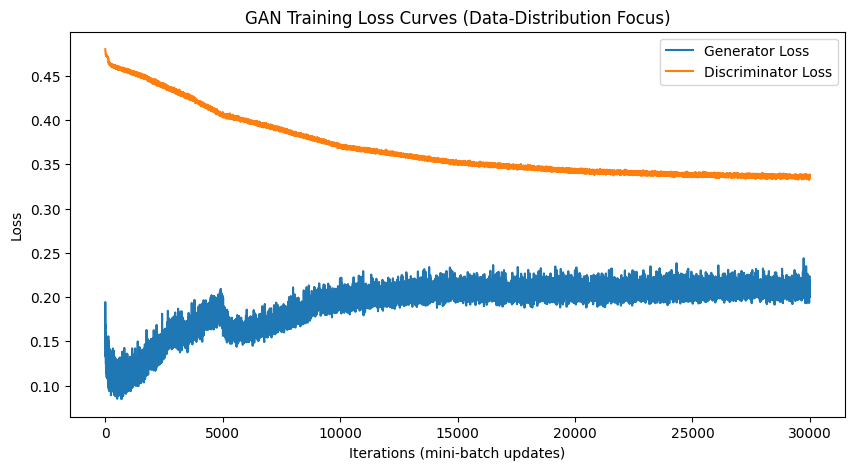

Starting VAE Training...
[VAE] Epoch [1/500] Batch [0/100] Loss: 772387.8125 Recon: 772381.1875 KL: 6624.0576
Epoch 1 complete (VAE).
[VAE] Epoch [2/500] Batch [0/100] Loss: 559736.1875 Recon: 559570.0000 KL: 166199.2500
Epoch 2 complete (VAE).
[VAE] Epoch [3/500] Batch [0/100] Loss: 505633.3125 Recon: 501656.4375 KL: 3976876.5000
Epoch 3 complete (VAE).
[VAE] Epoch [4/500] Batch [0/100] Loss: 398896.9062 Recon: 398773.6250 KL: 123282.9922
Epoch 4 complete (VAE).
[VAE] Epoch [5/500] Batch [0/100] Loss: 365308.1250 Recon: 365237.3750 KL: 70762.0938
Epoch 5 complete (VAE).
[VAE] Epoch [6/500] Batch [0/100] Loss: 313087.1875 Recon: 312989.1875 KL: 97985.9531
Epoch 6 complete (VAE).
[VAE] Epoch [7/500] Batch [0/100] Loss: 290159.1562 Recon: 290066.5625 KL: 92596.4609
Epoch 7 complete (VAE).
[VAE] Epoch [8/500] Batch [0/100] Loss: 274605.9375 Recon: 274515.6250 KL: 90323.3594
Epoch 8 complete (VAE).
[VAE] Epoch [9/500] Batch [0/100] Loss: 256594.4375 Recon: 256469.1875 KL: 125253.5625
Epoch

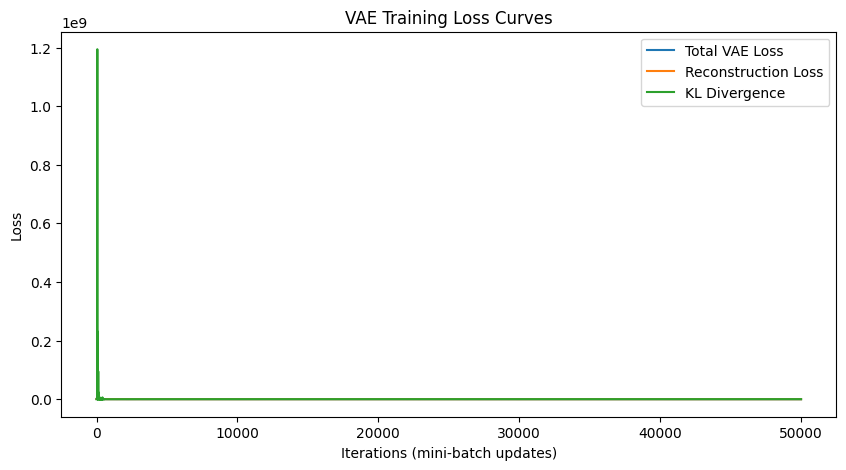

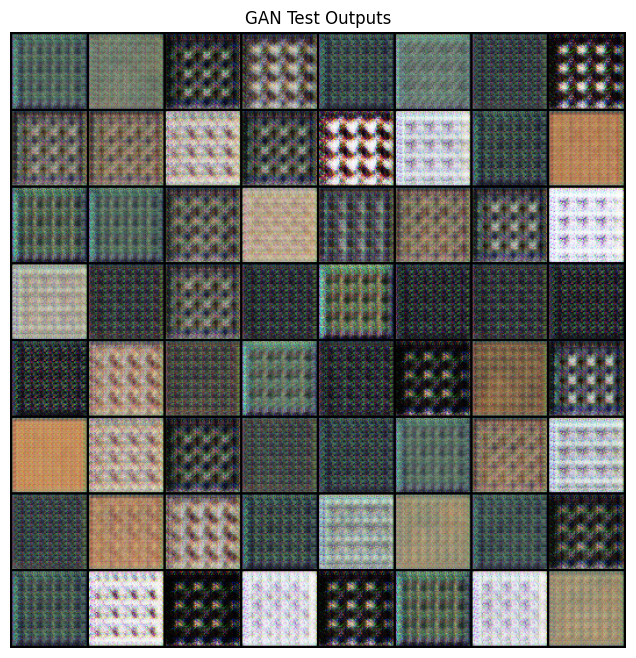

Average Similarity Score for Real Images (should be near 1): 0.9310


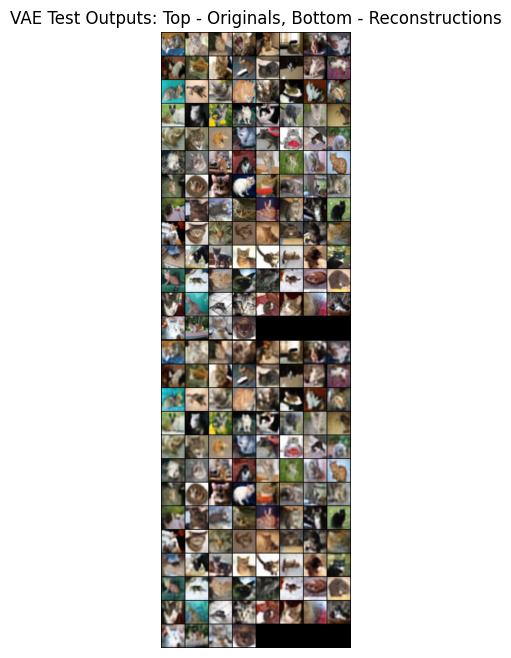

Average VAE Reconstruction Loss (L1): 971.3577


In [1]:
# =============================
# 0. Install and Import Libraries
# =============================
# !pip install torch==2.5.0
# !pip install torchvision
# !pip install progressbar2

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import progressbar

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms, datasets
from torchvision.utils import save_image, make_grid
from IPython import display

# =============================
# 1. Data Preparation
# =============================

OUTPUT_DIR = './data/CIFAR-10'
BATCH_SIZE = 100

# Transform: Resize to 64x64 and normalize to [-1,1]
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 training data using ImageFolder (assumes the data is already present)
train_path = "/kaggle/input/cifar10-pngs-in-folders/cifar10/train"
full_train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
# Filter for cats (label 3) and dogs (label 5)
selected_classes = [3, 5]
train_indices = [i for i, (_, label) in enumerate(full_train_dataset.samples) if label in selected_classes]
train_dataset = Subset(full_train_dataset, train_indices)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
print(f"Training dataset loaded with {len(train_dataset)} samples.")

# Load CIFAR-10 test data using ImageFolder (assumes the data is present)
test_path = "/kaggle/input/cifar10-pngs-in-folders/cifar10/test"
full_test_dataset = datasets.ImageFolder(root=test_path, transform=transform)
test_indices = [i for i, (_, label) in enumerate(full_test_dataset.samples) if label in selected_classes]
test_dataset = Subset(full_test_dataset, test_indices)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
print(f"Test dataset loaded with {len(test_dataset)} samples.")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# =============================
# 2. Model Definitions
# =============================

# ---- GAN Generator ----
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Generator maps 100-dim noise to a 3x64x64 image.
        self.linear = nn.Linear(100, 1024 * 4 * 4)
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.deconv4 = nn.Sequential(
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False)
        )
        self.output = nn.Tanh()  # Output in [-1,1]

    def forward(self, x):
        x = self.linear(x)
        x = x.view(x.size(0), 1024, 4, 4)
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = self.deconv4(x)
        return self.output(x)

# ---- Custom Siamese Discriminator for GAN ----
class SiameseDiscriminator(nn.Module):
    def __init__(self, feature_map_size=64, alpha=1e-6):
        """
        This discriminator extracts features from an input image via convolution,
        then compares two images by computing the exponential of the negative
        scaled squared L2 norm of their difference.
        """
        super(SiameseDiscriminator, self).__init__()
        self.alpha = alpha
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, feature_map_size, kernel_size=4, stride=2, padding=1),  # 64->32
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_map_size, feature_map_size*2, kernel_size=4, stride=2, padding=1),  # 32->16
            nn.BatchNorm2d(feature_map_size*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_map_size*2, feature_map_size*4, kernel_size=4, stride=2, padding=1),  # 16->8
            nn.BatchNorm2d(feature_map_size*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3)
        )
    
    def forward(self, img1, img2):
        f1 = self.feature_extractor(img1)
        f2 = self.feature_extractor(img2)
        f1 = f1.view(f1.size(0), -1)
        f2 = f2.view(f2.size(0), -1)
        diff = f1 - f2
        dist_sq = torch.sum(diff ** 2, dim=1, keepdim=True)
        score = torch.exp(-self.alpha * dist_sq)
        return score

# ---- VAE Model ----
class VAE(nn.Module):
    def __init__(self, latent_dim=512, feature_map_size=64):
        super(VAE, self).__init__()
        # Encoder: 3x64x64 -> down to 4x4 feature map
        self.encoder = nn.Sequential(
            nn.Conv2d(3, feature_map_size, kernel_size=4, stride=2, padding=1),   # 64->32
            nn.ReLU(inplace=True),
            nn.Conv2d(feature_map_size, feature_map_size*2, kernel_size=4, stride=2, padding=1),  # 32->16
            nn.BatchNorm2d(feature_map_size*2),
            nn.ReLU(inplace=True),
            nn.Conv2d(feature_map_size*2, feature_map_size*4, kernel_size=4, stride=2, padding=1),  # 16->8
            nn.BatchNorm2d(feature_map_size*4),
            nn.ReLU(inplace=True),
            nn.Conv2d(feature_map_size*4, feature_map_size*8, kernel_size=4, stride=2, padding=1),  # 8->4
            nn.BatchNorm2d(feature_map_size*8),
            nn.ReLU(inplace=True)
        )
        self.flatten = nn.Flatten()
        self.feature_dim = feature_map_size*8*4*4  # (feature_map_size*8) x 4 x 4
        self.fc_mu = nn.Linear(self.feature_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.feature_dim, latent_dim)
        
        # Decoder: latent vector -> 3x64x64 image
        self.fc_decode = nn.Linear(latent_dim, self.feature_dim)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (feature_map_size*8, 4, 4)),
            nn.ConvTranspose2d(feature_map_size*8, feature_map_size*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_map_size*4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(feature_map_size*4, feature_map_size*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_map_size*2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(feature_map_size*2, feature_map_size, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_map_size),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(feature_map_size, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Output in [-1,1]
        )
        
    def encode(self, x):
        x_enc = self.encoder(x)
        x_enc = self.flatten(x_enc)
        mu = self.fc_mu(x_enc)
        logvar = self.fc_logvar(x_enc)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        x = self.fc_decode(z)
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

# =============================
# 3. Loss Functions
# =============================

# GAN Losses (LS-GAN formulation):
def ls_gan_discriminator_loss(D_real, D_fake):
    loss_real = torch.mean((D_real - 1.0)**2)
    loss_fake = torch.mean(D_fake**2)
    return 0.5 * (loss_real + loss_fake)

def ls_gan_generator_loss(D_fake):
    return 0.5 * torch.mean((D_fake - 1.0)**2)

# VAE Loss (L1 reconstruction + KL Divergence)
def vae_loss(recon, x, mu, logvar, kl_weight=0.001):
    recon_loss = nn.functional.l1_loss(recon, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_weight * kl_loss, recon_loss, kl_loss

# Optional Feature Matching Loss for GAN:
lambda_fmatch = 0.2
def feature_matching_loss(real_imgs, fake_imgs, discriminator):
    # Use the discriminator's feature extractor (from one of the conv layers)
    # Here we extract features from conv4 (as an example)
    # To keep it simple, we pass images through the entire network and use the penultimate layer.
    # For our Siamese discriminator, you might re-define a method to extract features.
    with torch.no_grad():
        real_features = discriminator.feature_extractor(real_imgs)
    fake_features = discriminator.feature_extractor(fake_imgs)
    return nn.functional.l1_loss(fake_features.mean(dim=0), real_features.mean(dim=0))

# =============================
# 4. Optimizers and LR Schedulers
# =============================

# GAN Hyperparameters:
gan_latent_dim = 100  # Generator input dimension (noise vector)
g_lr = 3e-4           # Generator learning rate (increased to help update generator)
d_lr = 1e-4           # Discriminator learning rate
beta1 = 0.5

# Instantiate GAN models using the custom architectures.
generator = Generator().to(device)
# Use the Siamese Discriminator for similarity evaluation.
discriminator = SiameseDiscriminator(feature_map_size=64, alpha=1e-6).to(device)

g_optimizer = optim.Adam(generator.parameters(), lr=g_lr, betas=(beta1, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=d_lr, betas=(beta1, 0.999))

schedulerG = torch.optim.lr_scheduler.StepLR(g_optimizer, step_size=50, gamma=0.5)
schedulerD = torch.optim.lr_scheduler.StepLR(d_optimizer, step_size=50, gamma=0.5)

# VAE Hyperparameters:
vae_latent_dim = 512
vae_lr = 1e-5

vae = VAE(latent_dim=vae_latent_dim, feature_map_size=64).to(device)
vae_optimizer = optim.Adam(vae.parameters(), lr=vae_lr)
schedulerVAE = torch.optim.lr_scheduler.StepLR(vae_optimizer, step_size=50, gamma=0.5)

# =============================
# 5. Training Loops
# =============================

# =============================
# 5. GAN Training Loop (Updated Loss Focus)
# =============================

gan_loss_history = {"G": [], "D": []}
num_epochs_gan = 300  # Total epochs for GAN training

# New hyperparameters for generator loss weighting:
lambda_adv = 0.1      # Low weight on adversarial loss
lambda_fmatch = 0.9   # High weight on feature matching loss

print("Starting GAN Training with Updated Loss (Data Distribution Focus)...")

for epoch in range(1, num_epochs_gan + 1):
    # For this example, we update both networks in every epoch (or even every mini-batch).
    for i, (imgs, _) in enumerate(train_loader):
        batch_size = imgs.size(0)
        real_imgs = imgs.to(device)
        
        # ---------------------------
        # Discriminator Update (Mini-Batch)
        # ---------------------------
        noise = torch.randn(batch_size, gan_latent_dim, device=device)
        fake_imgs = generator(noise)
        # For the discriminator, we compare two cases:
        # - (real, real): should produce similarity near 1.
        # - (real, fake): should produce similarity near 0.
        D_real = discriminator(real_imgs, real_imgs)
        D_fake = discriminator(real_imgs, fake_imgs.detach())
        
        d_optimizer.zero_grad()
        loss_D = ls_gan_discriminator_loss(D_real, D_fake)
        loss_D.backward()
        d_optimizer.step()
        gan_loss_history["D"].append(loss_D.item())
        
        # ---------------------------
        # Generator Update (Mini-Batch)
        # ---------------------------
        noise = torch.randn(batch_size, gan_latent_dim, device=device)
        fake_imgs = generator(noise)
        D_fake = discriminator(real_imgs, fake_imgs)
        
        g_optimizer.zero_grad()
        # Standard adversarial loss (generator wants D_fake to be 1)
        loss_G_adv = ls_gan_generator_loss(D_fake)
        # Feature matching loss compares real and fake feature statistics from the discriminator
        fm_loss = feature_matching_loss(real_imgs, fake_imgs, discriminator)
        # Combined generator loss: We give a high weight to matching the data distribution.
        loss_G_total = lambda_adv * loss_G_adv + lambda_fmatch * fm_loss
        loss_G_total.backward()
        g_optimizer.step()
        gan_loss_history["G"].append(loss_G_total.item())
        
        if i % 100 == 0:
            print(f"[GAN] Epoch [{epoch}/{num_epochs_gan}] Batch [{i}/{len(train_loader)}] "
                  f"Loss_D: {loss_D.item():.4f} Loss_G: {loss_G_total.item():.4f}")
    
    schedulerG.step()
    schedulerD.step()
    
    # Save sample outputs at end of each epoch.
    sample_folder = "gan_samples"
    os.makedirs(sample_folder, exist_ok=True)
    with torch.no_grad():
        num_samples = min(5, real_imgs.size(0))
        real_sample = real_imgs[:num_samples]
        noise_sample = torch.randn(num_samples, gan_latent_dim, device=device)
        fake_sample = generator(noise_sample)
        grid = torchvision.utils.make_grid(torch.cat([real_sample, fake_sample], dim=0),
                                             nrow=num_samples, normalize=True)
        save_image(grid, os.path.join(sample_folder, f"epoch_{epoch}.png"))
    
    print(f"Epoch {epoch} complete (GAN).")

print("GAN Training Completed.")

plt.figure(figsize=(10,5))
plt.plot(gan_loss_history["G"], label="Generator Loss")
plt.plot(gan_loss_history["D"], label="Discriminator Loss")
plt.xlabel("Iterations (mini-batch updates)")
plt.ylabel("Loss")
plt.title("GAN Training Loss Curves (Data-Distribution Focus)")
plt.legend()
plt.show()

# ---- VAE Training Loop ----
vae_loss_history = {"total": [], "recon": [], "kl": []}
num_epochs_vae = 500

print("Starting VAE Training...")
vae.train()
for epoch in range(1, num_epochs_vae + 1):
    for i, (imgs, _) in enumerate(train_loader):
        imgs = imgs.to(device)
        vae_optimizer.zero_grad()
        recon, mu, logvar = vae(imgs)
        total_loss, recon_loss, kl_loss = vae_loss(recon, imgs, mu, logvar, kl_weight=0.001)
        total_loss.backward()
        vae_optimizer.step()
        vae_loss_history["total"].append(total_loss.item())
        vae_loss_history["recon"].append(recon_loss.item())
        vae_loss_history["kl"].append(kl_loss.item())
        if i % 100 == 0:
            print(f"[VAE] Epoch [{epoch}/{num_epochs_vae}] Batch [{i}/{len(train_loader)}] Loss: {total_loss.item():.4f} Recon: {recon_loss.item():.4f} KL: {kl_loss.item():.4f}")
    schedulerVAE.step()
    
    sample_folder_vae = "vae_samples"
    os.makedirs(sample_folder_vae, exist_ok=True)
    with torch.no_grad():
        recon, _, _ = vae(imgs)
        imgs_denorm = (imgs + 1) / 2
        recon_denorm = (recon + 1) / 2
        n = min(8, imgs.size(0))
        grid_orig = torchvision.utils.make_grid(imgs_denorm[:n], nrow=n)
        grid_recon = torchvision.utils.make_grid(recon_denorm[:n], nrow=n)
        combined = torch.cat([grid_orig, grid_recon], dim=1)
        save_image(combined, os.path.join(sample_folder_vae, f"epoch_{epoch}.png"))
    print(f"Epoch {epoch} complete (VAE).")

print("VAE Training Completed.")

plt.figure(figsize=(10,5))
plt.plot(vae_loss_history["total"], label="Total VAE Loss")
plt.plot(vae_loss_history["recon"], label="Reconstruction Loss")
plt.plot(vae_loss_history["kl"], label="KL Divergence")
plt.xlabel("Iterations (mini-batch updates)")
plt.ylabel("Loss")
plt.title("VAE Training Loss Curves")
plt.legend()
plt.show()

# =============================
# 6. Testing Code and Quantitative Evaluation
# =============================

# --- Testing GAN ---
generator.eval()
with torch.no_grad():
    noise = torch.randn(64, gan_latent_dim, device=device)
    fake_test = generator(noise)
    fake_test = (fake_test + 1) / 2  # Denormalize to [0,1]
    grid_test = make_grid(fake_test, nrow=8)
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(grid_test.cpu().numpy(), (1,2,0)))
    plt.title("GAN Test Outputs")
    plt.axis("off")
    plt.show()
    save_image(fake_test, "gan_test_outputs.png", nrow=8, normalize=True)

# --- Evaluate GAN Quantitatively ---
# For quantitative similarity evaluation, compute the average discriminator score
# for a set of real-real pairs from the test set. Since the Siamese discriminator
# should output values near 1 for identical pairs, we measure that.
with torch.no_grad():
    scores = []
    for imgs, _ in test_loader:
        imgs = imgs.to(device)
        score = discriminator(imgs, imgs)
        scores.append(score.mean().item())
    avg_similarity = np.mean(scores)
    print(f"Average Similarity Score for Real Images (should be near 1): {avg_similarity:.4f}")

# --- Testing VAE ---
vae.eval()
with torch.no_grad():
    data_iter = iter(test_loader)
    test_imgs, _ = next(data_iter)
    test_imgs = test_imgs.to(device)
    recon_test, _, _ = vae(test_imgs)
    test_imgs_denorm = (test_imgs + 1) / 2
    recon_test_denorm = (recon_test + 1) / 2
    grid_orig = make_grid(test_imgs_denorm, nrow=8)
    grid_recon = make_grid(recon_test_denorm, nrow=8)
    combined_test = torch.cat([grid_orig, grid_recon], dim=1)
    plt.figure(figsize=(16,8))
    plt.imshow(np.transpose(combined_test.cpu().numpy(), (1,2,0)))
    plt.title("VAE Test Outputs: Top - Originals, Bottom - Reconstructions")
    plt.axis("off")
    plt.show()
    save_image(combined_test, "vae_test_outputs.png", normalize=True)

# --- Quantitative Evaluation for VAE ---
total_recon_loss = 0
count = 0
with torch.no_grad():
    for imgs, _ in test_loader:
        imgs = imgs.to(device)
        recon, _, _ = vae(imgs)
        recon_loss = nn.functional.l1_loss(recon, imgs, reduction='sum').item()
        total_recon_loss += recon_loss
        count += imgs.size(0)
avg_recon_loss = total_recon_loss / count
print(f"Average VAE Reconstruction Loss (L1): {avg_recon_loss:.4f}")
